In [ ]:
# 모듈 import
from mmcv import Config
from mmseg.datasets import build_dataset
from mmseg.models import build_detector
from mmseg.apis import train_detector
from mmseg.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

In [27]:
# multilabelStratifiedKfold
import os
import json
import numpy as np
import pandas as pd
import argparse

from tqdm import tqdm

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# image 경로
data_path = '/opt/ml/input/data/'
images_path = os.path.join(data_path, 'train')

# annotation 경로
annotations_path = os.path.join(data_path,'train_all.json')

# 생성할 fold 개수
kfold = 5

# 생성된 fold를 저장할 폴더 경로 지정
path = './stratified_kfold'

# Stratified kfold 진행
def main():
    with open(annotations_path, 'r') as f:
        train_json = json.loads(f.read())
        images = train_json['images']
        categories = train_json['categories']
        annotations = train_json['annotations']

    annotations_df = pd.DataFrame.from_dict(annotations)
    x = images
    y = [[0] * len(categories) for _ in range(len(images))]
    
    # return len(annotations_df['category_id'].unique()), len(categories)
    # return len(y),len(annotations),len(categories),len(images)
    
    # for anno in annotations:
        # y[anno['image_id']][anno['category_id']] += 1

    mskf = MultilabelStratifiedKFold(n_splits=kfold, shuffle=True)


    if not os.path.exists(path):
        os.mkdir(path)

    for idx, (train_index, val_index) in tqdm(enumerate(mskf.split(x, y)), total=kfold):
        train_dict = dict()
        val_dict = dict()
        for i in ['info', 'licenses', 'categories']:
            train_dict[i] = train_json[i]
            val_dict[i] = train_json[i]
        train_dict['images'] = np.array(images)[train_index].tolist()
        val_dict['images'] = np.array(images)[val_index].tolist()
        train_dict['annotations'] = annotations_df[annotations_df['image_id'].isin(train_index)].to_dict('records')
        val_dict['annotations'] = annotations_df[annotations_df['image_id'].isin(val_index)].to_dict('records')

        train_dir = os.path.join(path, f'cv_train_{idx + 1}.json')
        val_dir = os.path.join(path, f'cv_val_{idx + 1}.json')
        with open(train_dir, 'w') as train_file:
            json.dump(train_dict, train_file)

        with open(val_dir, 'w') as val_file:
            json.dump(val_dict, val_file)

    print("Done Make files")


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--path', '-p', type=str, default='./stratified_kfold')
#     parser.add_argument('--n_split', '-n', type=int, default=5)
#     arg = parser.parse_args()
#     main(arg)
main()

100%|██████████| 5/5 [01:36<00:00, 19.40s/it]


Done Make files


In [33]:
for i in range(1,6):
    with open('./stratified_kfold/cv_train_'+ str(i) + '.json') as f:
        train = json.load(f)
    with open('./stratified_kfold/cv_val_'+ str(i) + '.json') as f:  
        valid = json.load(f)
    print(len(train['images']),len(valid['images']))

2618 654
2618 654
2617 655
2617 655
2618 654


In [39]:
# Read annotations
with open('./stratified_kfold/cv_train_1.json', 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

/tmp/ipykernel_27259/3924265882.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  df = df.sort_values('Number of annotations', 0, False)


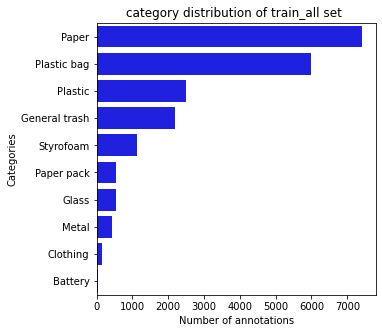

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")